# 🌤 Project #1: Explore Weather Trends

## Summary

This is the first project in the Udacity's Data Analyst Nanodegree Program: Course 1.

In this project, we will
- analyze local and global temperature data, and 
- compare the temperature trends where I live to overall global temperature trends.

## Objectives

The objectives are to
- Extract data from database using SQL query.
- Manipulate data using Python programming.
- Create data visualization. A line chart is included in the submission.
- Interpret and prepare a write up describing the similarities and differences between global temperature trends and temperature trends in the city where I live.

## Database Schema

There are three tables in the database:

- **city_list** - This contains a list of cities and countries in the database. Look through them in order to find the city nearest to you.
- **city_data** - This contains the average temperatures for each city by year (ºC).
- **global_data** - This contains the average global temperatures by year (ºC).

***

## Accessing Data with SQL

First, we extract the data set using SQL query on Udacity's website. 

````sql
-- Extract global and Malaysia's temperature data
SELECT 
    g.year, 
    g.avg_temp AS global_temp, 
    c.country,  
    c.city, 
    c.avg_temp AS malaysia_temp
FROM global_data g
JOIN city_data c
    ON g.year = c.year
WHERE c.city = 'Kuala Lumpur';
````

My city selection is **Kuala Lumpur**. The output shows that there are 188 results. Then, I proceed to download the CSV file.

## Preparing the Environment

We will import the required libraries and read the data set.

- Pandas - Data manipulation
- Numpy - Data arrays
- Matplotlib & Seaborn - Data visualisation

In [35]:
# Import libraries and alias for easy reading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Read in data in CSV format
temperature = pd.read_csv('/Users/katiehuang/Documents/Data Analytics/Udacity Data Analyst Nanodegree/Project 1 - Explore Weather Trends/temperature.csv')

## Exploring Data Set

Let's have a look at the data using `df.head()`, `df.info()` and `df.describe()`.

In [3]:
# Preview first 5 rows of data set
temperature.head()

,year,global_temp,country,city,malaysia_temp
0,1825,8.39,Malaysia,Kuala Lumpur,26.46
1,1826,8.36,Malaysia,Kuala Lumpur,NaN
2,1827,8.81,Malaysia,Kuala Lumpur,NaN
3,1828,8.17,Malaysia,Kuala Lumpur,NaN
4,1829,7.94,Malaysia,Kuala Lumpur,NaN


In [4]:
# Summarised information of data set
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           189 non-null    int64  
 1   global_temp    189 non-null    float64
 2   country        189 non-null    object 
 3   city           189 non-null    object 
 4   malaysia_temp  172 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.5+ KB


From the summary, we can see that
- There are a total of 188 rows and 5 columns in the data set.
- Data types are correct and matches the corresponding values. 
- `malaysia_temp` column has null values.

Let's perform some data cleaning.

***

## Data Cleaning

Before we start with analysis, we must first clean the data or "scrub the dirt".

For this step, we will look at the more common issues such as missing and duplicate data.

**Handling Missing Values**

Now, we will find out whether there are Null values.

In [5]:
# Find the number of null values for all columns
temperature.isnull().sum()

year              0
global_temp       0
country           0
city              0
malaysia_temp    17
dtype: int64

The result confirms that `malaysia_temp` has 17 NULL values.

In [6]:
# Drop the NULL values
temperature = temperature.dropna()

# Reset index after dropping NULL values
temperature = temperature.reset_index(drop=True)

# Confirm that NULL values have been dropped from data set
temperature.isnull().sum()

year             0
global_temp      0
country          0
city             0
malaysia_temp    0
dtype: int64

**Duplicate Data**

Next, we will find out whether there are any duplicate data.

In [7]:
# Find the number of duplicate data
temperature.duplicated().sum()

0

Output shows that there are no duplicated data. 

OK, let's run another `df.info()` for good measure to confirm that our data is ready for analysis.

In [8]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           172 non-null    int64  
 1   global_temp    172 non-null    float64
 2   country        172 non-null    object 
 3   city           172 non-null    object 
 4   malaysia_temp  172 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.8+ KB


***

## Descriptive Statistics

Here, we will do a descriptive statistical analysis and use `df.describe()`.

In [9]:
# Descriptive Statistics summary
temperature.describe()

,year,global_temp,malaysia_temp
count,172.000000,172.000000,172.000000
mean,1927.087209,8.535116,26.566570
std,50.478859,0.464371,0.478242
min,1825.000000,7.630000,25.590000
25%,1884.750000,8.180000,26.202500
50%,1927.500000,8.520000,26.575000
75%,1970.250000,8.760000,26.922500
max,2013.000000,9.730000,27.890000


From the statistical info, we observe that the lowest global temperature on average is 7.63ºC! Which is -2.35x of Malaysia's chilliest weather.

It is also interesting to note that the highest global temperature on average is 9.73ºC, meaning that we have some very cold countries that are pulling the average down.

***

## Moving Average for Time-Series Analysis

Before we move on to the actual analysis, we have to find the moving averages of the temperature. 

### What is Moving Average

``` Moving Average is used to analyse time-series data by calculating average of different subsets of a data set. ```

It involves averaging the values of a fixed subset or, in our case, **averaging the temperature for a fixed period of years** and then, the subset is changed by moving forward to the next fixed subset. 

> For context, let's say we want to calculate the 10-years moving average for our data set. First, we calculate the average temperature from year 2000 to 2010. Then, we roll the subset forward by 1 year and calculate the average temperature for year 2001 to 2011 and, it goes on until we reached the end of the data set.

### Calculating 10-Years Moving Average

We will be using the Simple Moving Average (SMA) method. 

Let's calculate SMA for a window size of 10 years using the `rolling()` function.

In [10]:
# Calculating 10-years moving average
temperature['global_10y_ma'] = temperature.iloc[:,1].rolling(window=10).mean()
temperature['msia_10y_ma'] = temperature.iloc[:,4].rolling(window=10).mean()

# Preview 1st 20 rows to confirm new moving average columns
temperature.head(20)

,year,global_temp,country,city,malaysia_temp,global_10y_ma,msia_10y_ma
0,1825,8.39,Malaysia,Kuala Lumpur,26.46,NaN,NaN
1,1839,7.63,Malaysia,Kuala Lumpur,25.74,NaN,NaN
2,1840,7.80,Malaysia,Kuala Lumpur,25.96,NaN,NaN
3,1841,7.69,Malaysia,Kuala Lumpur,26.10,NaN,NaN
4,1842,8.02,Malaysia,Kuala Lumpur,26.18,NaN,NaN
5,1843,8.17,Malaysia,Kuala Lumpur,26.25,NaN,NaN
6,1844,7.65,Malaysia,Kuala Lumpur,25.77,NaN,NaN
7,1845,7.85,Malaysia,Kuala Lumpur,25.64,NaN,NaN
8,1846,8.55,Malaysia,Kuala Lumpur,26.44,NaN,NaN
9,1847,8.09,Malaysia,Kuala Lumpur,25.89,7.984,26.043


We can see that the 1st 10 rows are NaN (Not a Number) as the moving average is calculated using the 1st 10 rows hence, the calculated 10-year moving average value only starts at index no. 22.

***

## Data Analysis and Visualization

### Line Chart

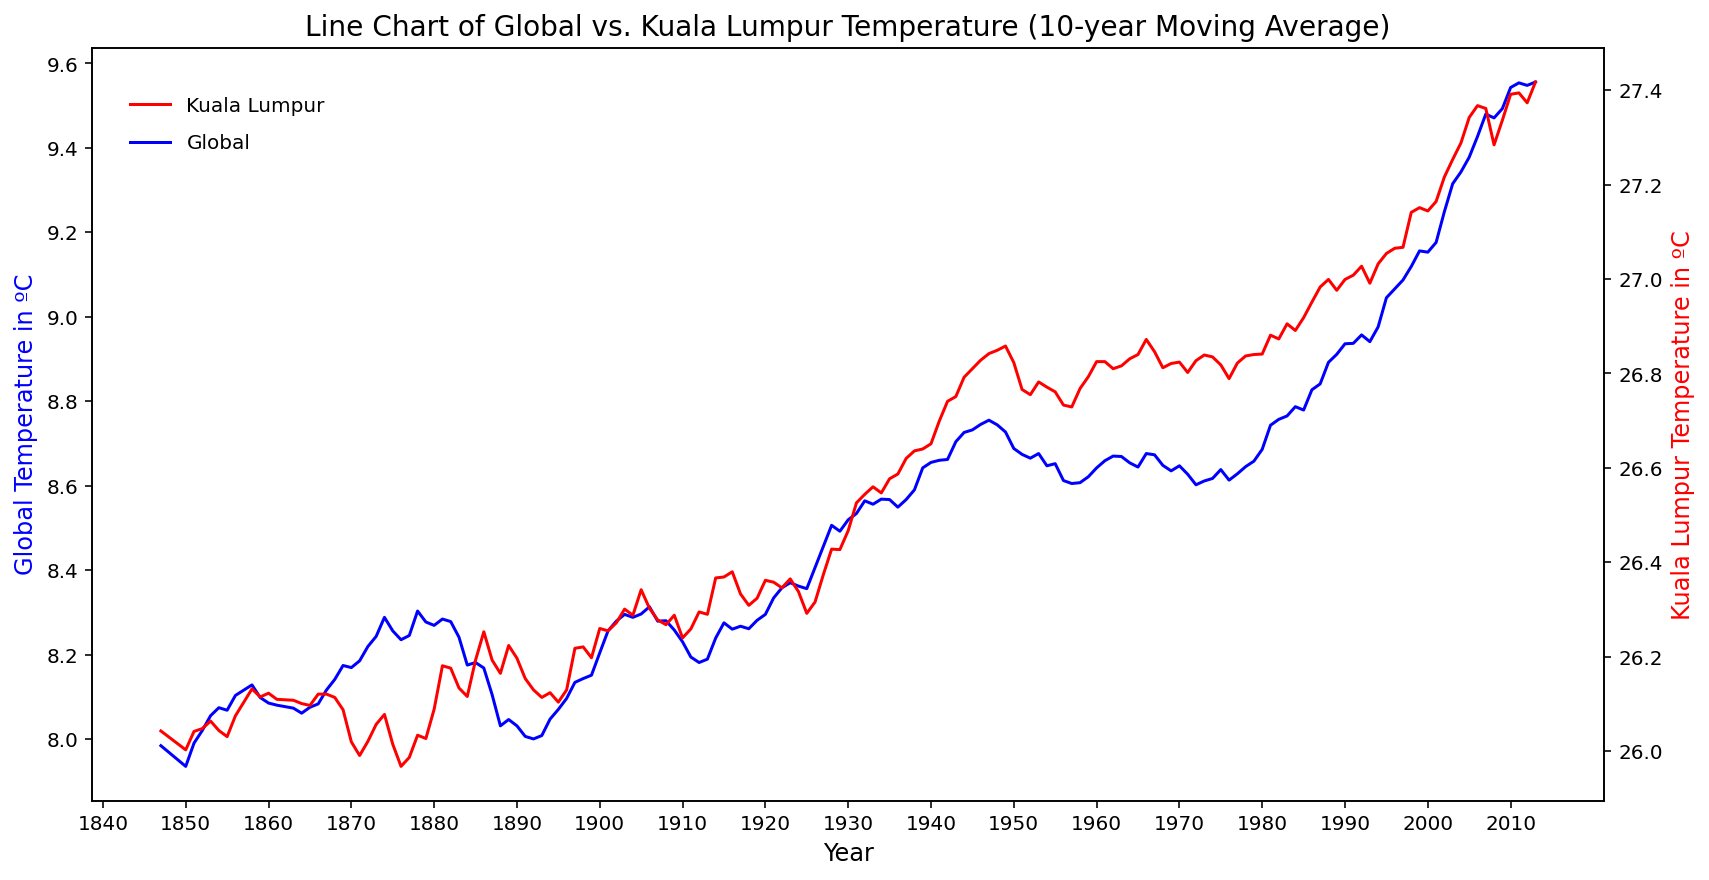

In [37]:
# Plotting line chart
fig, ax = plt.subplots(figsize=[12,6])

# Plotting for Global Temperature
ax.plot(temperature.year, temperature.global_10y_ma, label='Global', color='blue')
plt.xticks(np.arange(0, max(temperature.year)+1, 10))
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Global Temperature in ºC', color='blue', size=12)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(loc=[0.02,0.85], frameon=False)

# Instantiate a second axes that shares the same x-axis
ax1 = ax.twinx()

# Plotting for Kuala Lumpur Temperature
ax1.plot(temperature.year, temperature.msia_10y_ma, label='Kuala Lumpur', color='red')
ax1.set_ylabel('Kuala Lumpur Temperature in ºC', color='red', size=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc=[0.02,0.9], frameon=False)

fig.tight_layout()
ax1.set_title("Line Chart of Global vs. Kuala Lumpur Temperature (10-year Moving Average)", size=14)
plt.show()

The line chart above shows the 10-year moving average of global and Kuala Lumpur's temperature from mid 18th century to the 20th century. 

We observe that
- Global and Kuala Lumpur temperature has a similar line pattern and both are increasing steadily, especially at the end of 19th century and early 20th century.
- Increase of overall temperature is most likely due to global warming and we should e


### Correlation Coefficient

We will find out the relationship between years and temperature using the `corr()` function.

In [12]:
# Getting the correlation coefficient
corr = temperature.corr()
corr

,year,global_temp,malaysia_temp,global_10y_ma,msia_10y_ma
year,1.000000,0.856680,0.862513,0.922046,0.971210
global_temp,0.856680,1.000000,0.893495,0.926285,0.890161
malaysia_temp,0.862513,0.893495,1.000000,0.869262,0.896811
global_10y_ma,0.922046,0.926285,0.869262,1.000000,0.961499
msia_10y_ma,0.971210,0.890161,0.896811,0.961499,1.000000


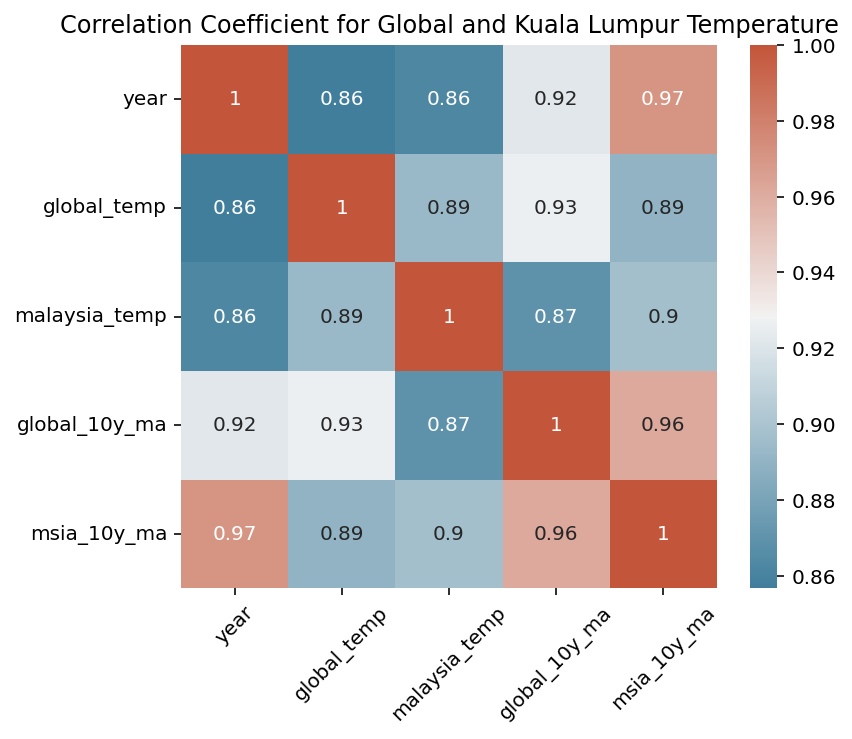

In [36]:
# Plotting matrix heatmap
plt.figure(figsize=[6,5])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.xticks(rotation=45)
plt.title("Correlation Coefficient for Global and Kuala Lumpur Temperature", size=12)
plt.show()

Based on the heatmap, we can see that there is a higher correlation between `year` with `global_10y_ma' and `msia_10y_ma` and a slightly weaker correlation between `year` with `global_10y_ma' and `msia_10y_ma`.

## Conclusion

In conclusion:
- The increase in overall global and Kuala Lumpur temperature are most likely due to global warming and we should expect a more vertical increase in the future.
- The world is becoming hotter on average and the changes are consistent over time.
- In the recent years in 2020 and 2021, we can expect slow down or minimal rise in global temperature due to the Covid-19 pandemic as people have been mostly staying home due to lockdown and businesses' operations have also reduced significantly.

***

### 📚 References

1. [DataCamp: Moving Averages in Pandas](https://www.datacamp.com/community/tutorials/moving-averages-in-pandas)
2. [NumPy, SciPy, and Pandas: Correlation With Python](https://realpython.com/numpy-scipy-pandas-correlation-python/)

Thank you for reading! Give a 🌟 if you like this analysis.